In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [ ]:
df = pd.read_csv('/content/SAMSUNG.csv')
df1=df.reset_index()['Close']

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [40]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.4 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [41]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [42]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [43]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [44]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [45]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 114ms/step - loss: 0.1933 - val_loss: 0.0090
Epoch 2/100
13/13 [==============================] - 1s 58ms/step - loss: 0.0253 - val_loss: 0.0116
Epoch 3/100
13/13 [==============================] - 1s 58ms/step - loss: 0.0120 - val_loss: 0.0053
Epoch 4/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0091 - val_loss: 0.0023
Epoch 5/100
13/13 [==============================] - 1s 57ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 6/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 7/100
13/13 [==============================] - 1s 57ms/step - loss: 0.0016 - val_loss: 7.8080e-04
Epoch 8/100
13/13 [==============================] - 1s 59ms/step - loss: 0.0010 - val_loss: 6.8603e-04
Epoch 9/100
13/13 [==============================] - 1s 57ms/step - loss: 8.5673e-04 - val_loss: 6.6601e-04
Epoch 10/100
13/13 [==============================] - 1s 55ms/step - loss: 8.3131e-

In [46]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

17/17 [==============================] - 0s 12ms/step


In [47]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [48]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 67721.86716351408


# Dự đoán 30 ngày tiếp theo

In [49]:
import numpy as np

x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        # Lấy 100 bước thời gian gần nhất từ temp_input
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, 100, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(x_input, verbose=0)
        # Thêm giá trị dự đoán vào temp_input
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        # Tiếp tục lặp lại
        i += 1
    else:
        # Nếu temp_input chưa đủ dữ liệu, sử dụng nó như một mẫu đầu vào
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, len(temp_input), 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(x_input, verbose=0)
        # Thêm giá trị dự đoán vào temp_input
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

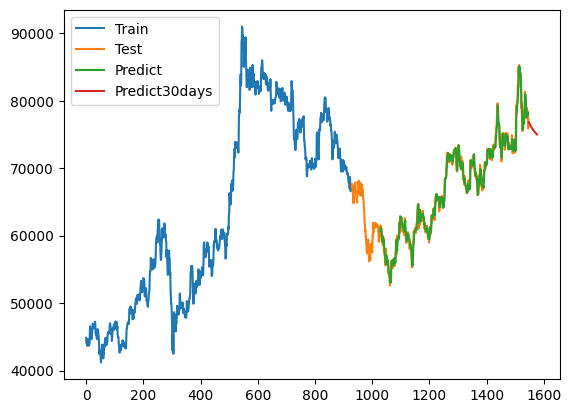

In [50]:
# Plotting
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=train_size + n_steps, stop=train_size + n_steps + len(y_pred), step=1)
plt.plot(test_data_index_pred, y_pred)

# Adjusting lst_output to have correct shape and length
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + len(lst_output), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output))

plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()


# Dự đoán 60 ngày tiếp theo

In [51]:
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0
while(i < 60):

    if(len(temp_input) > 100):
        # Chỉ lấy 100 phần tử cuối cùng
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        # Dự đoán
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1


0 day input [0.64056225 0.64056225 0.65662651 0.63052209 0.59839357 0.6124498
 0.67269076 0.67269076 0.68072289 0.68273092 0.65863454 0.66064257
 0.64658635 0.64658635 0.66666667 0.66465863 0.63253012 0.65060241
 0.68273092 0.68273092 0.66465863 0.66666667 0.67871486 0.66064257
 0.66064257 0.68273092 0.65863454 0.63855422 0.63453815 0.63453815
 0.65461847 0.64457831 0.63855422 0.64056225 0.63654618 0.63654618
 0.63453815 0.63654618 0.64257028 0.64658635 0.64658635 0.67670683
 0.65261044 0.63654618 0.62248996 0.64457831 0.64457831 0.62650602
 0.64457831 0.66064257 0.66465863 0.62449799 0.62449799 0.63453815
 0.63453815 0.71686747 0.76506024 0.75702811 0.74297189 0.77710843
 0.7751004  0.79518072 0.82730924 0.81927711 0.87951807 0.86144578
 0.88554217 0.86947791 0.86947791 0.85140562 0.86144578 0.85341365
 0.82329317 0.77911647 0.75702811 0.77108434 0.73092369 0.70080321
 0.68875502 0.75100402 0.70481928 0.71285141 0.71285141 0.72891566
 0.73895582 0.73092369 0.80522088 0.80522088 0.7730

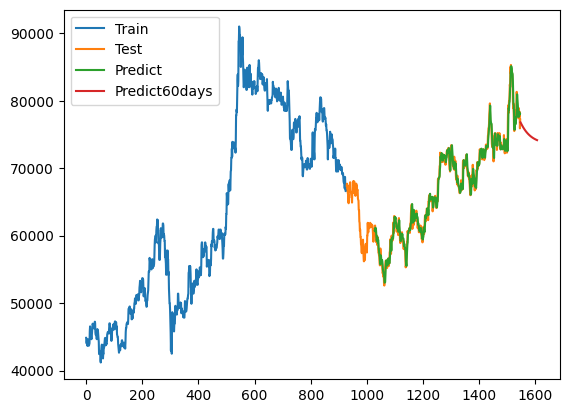

In [52]:
# Plotting
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=train_size + n_steps, stop=train_size + n_steps + len(y_pred), step=1)
plt.plot(test_data_index_pred, y_pred)

# Adjusting lst_output to have correct shape and length
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + len(lst_output_60), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output_60))

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

# Dự đoán 90 ngày tiếp theo

In [53]:
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        # Chỉ lấy 100 phần tử cuối cùng
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        # Dự đoán
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1


0 day input [0.64056225 0.64056225 0.65662651 0.63052209 0.59839357 0.6124498
 0.67269076 0.67269076 0.68072289 0.68273092 0.65863454 0.66064257
 0.64658635 0.64658635 0.66666667 0.66465863 0.63253012 0.65060241
 0.68273092 0.68273092 0.66465863 0.66666667 0.67871486 0.66064257
 0.66064257 0.68273092 0.65863454 0.63855422 0.63453815 0.63453815
 0.65461847 0.64457831 0.63855422 0.64056225 0.63654618 0.63654618
 0.63453815 0.63654618 0.64257028 0.64658635 0.64658635 0.67670683
 0.65261044 0.63654618 0.62248996 0.64457831 0.64457831 0.62650602
 0.64457831 0.66064257 0.66465863 0.62449799 0.62449799 0.63453815
 0.63453815 0.71686747 0.76506024 0.75702811 0.74297189 0.77710843
 0.7751004  0.79518072 0.82730924 0.81927711 0.87951807 0.86144578
 0.88554217 0.86947791 0.86947791 0.85140562 0.86144578 0.85341365
 0.82329317 0.77911647 0.75702811 0.77108434 0.73092369 0.70080321
 0.68875502 0.75100402 0.70481928 0.71285141 0.71285141 0.72891566
 0.73895582 0.73092369 0.80522088 0.80522088 0.7730

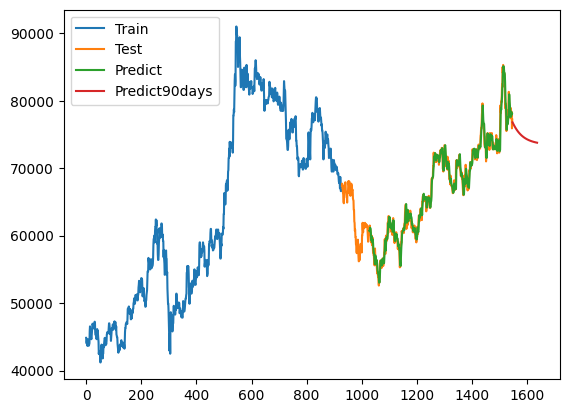

In [54]:
# Plotting
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=train_size + n_steps, stop=train_size + n_steps + len(y_pred), step=1)
plt.plot(test_data_index_pred, y_pred)

# Adjusting lst_output to have correct shape and length
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + len(lst_output_90), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output_90))

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()